<a href="https://colab.research.google.com/github/LenguyenhungCS/CvT-ViT-CNN_Cifar100/blob/main/ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

ResNet18 Architecture

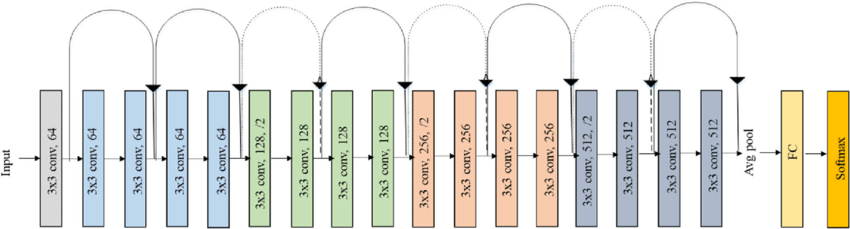

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1  # for ResNet-18 and ResNet-34

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
def resnet18(num_classes=100):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

rn18_model = resnet18()
num_params_rn18 = count_parameters(rn18_model)
print(f"Số lượng tham số của mô hình ResNet18 (cho CIFAR-100): {num_params_rn18:,}")

Số lượng tham số của mô hình ResNet18 (cho CIFAR-100): 11,220,132


In [ ]:
class EarlyStoppingAcc:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0


In [ ]:
class EarlyStoppingAcc:
    def __init__(self, patience=5, min_delta=0.001):
        """
        Dừng sớm khi độ chính xác (accuracy) không cải thiện trong một số epoch nhất định.

        Args:
            patience (int): Số epoch chờ trước khi dừng nếu không cải thiện.
            min_delta (float): Ngưỡng tối thiểu để được coi là cải thiện.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        """
        Kiểm tra độ chính xác hiện tại để xác định có nên dừng sớm không.

        Args:
            val_acc (float): Test accuracy hiện tại.
        """
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0

In [ ]:
import time

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    start_time = time.time()

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += outputs.argmax(1).eq(targets).sum().item()

    elapsed_time = time.time() - start_time
    acc = 100. * correct / len(loader.dataset)
    print(f"[Train] Loss: {total_loss / len(loader):.4f}, Acc: {acc:.2f}%, Time: {elapsed_time:.2f}s")
    return total_loss / len(loader), acc

def test(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    start_time = time.time()

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            correct += outputs.argmax(1).eq(targets).sum().item()

    elapsed_time = time.time() - start_time
    acc = 100. * correct / len(loader.dataset)
    print(f"[Test ] Loss: {total_loss / len(loader):.4f}, Acc: {acc:.2f}%, Time: {elapsed_time:.2f}s")
    return total_loss / len(loader), acc


In [ ]:
# Data transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),  # CIFAR-100 stats
])

# Load dataset
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


100%|██████████| 169M/169M [00:03<00:00, 49.0MB/s]


In [ ]:
early_stopping = EarlyStoppingAcc(patience=10, min_delta=0.001)

for epoch in range(1, 201):
    train_loss, train_acc = train(model, trainloader, optimizer, criterion)
    test_loss, test_acc = test(model, testloader, criterion)
    scheduler.step()

    print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    early_stopping(test_acc)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch}. Best accuracy: {early_stopping.best_score:.2f}%")
        break

[Train] Loss: 3.9929, Acc: 8.40%, Time: 40.38s
[Test ] Loss: 3.6303, Acc: 13.05%, Time: 3.82s
Epoch 001 | Train Acc: 8.40% | Test Acc: 13.05%
[Train] Loss: 3.3908, Acc: 17.36%, Time: 40.22s
[Test ] Loss: 3.2708, Acc: 20.08%, Time: 3.94s
Epoch 002 | Train Acc: 17.36% | Test Acc: 20.08%
[Train] Loss: 2.9541, Acc: 25.24%, Time: 41.48s
[Test ] Loss: 2.7847, Acc: 29.38%, Time: 3.87s
Epoch 003 | Train Acc: 25.24% | Test Acc: 29.38%
[Train] Loss: 2.5233, Acc: 34.15%, Time: 41.26s
[Test ] Loss: 2.4570, Acc: 35.14%, Time: 4.67s
Epoch 004 | Train Acc: 34.15% | Test Acc: 35.14%
[Train] Loss: 2.1733, Acc: 41.45%, Time: 41.39s
[Test ] Loss: 2.1826, Acc: 41.24%, Time: 3.79s
Epoch 005 | Train Acc: 41.45% | Test Acc: 41.24%
[Train] Loss: 1.9439, Acc: 46.62%, Time: 41.21s
[Test ] Loss: 2.0008, Acc: 44.71%, Time: 4.27s
Epoch 006 | Train Acc: 46.62% | Test Acc: 44.71%
[Train] Loss: 1.7698, Acc: 51.01%, Time: 41.35s
[Test ] Loss: 2.0481, Acc: 45.31%, Time: 3.87s
Epoch 007 | Train Acc: 51.01% | Test Acc: 4